In [54]:
from surface_dynamics.all import Origami
import numpy as np

In [55]:
def cycle_notation(array): 
    '''
        Argument: array of integers representing gluing instruction of origami, every element in array is glued to the next
        Return: string representing the cycle of the gluing
        Comment: assumes array is a permutation we are using which is a cycle as we are gluing the boxes
            until the edges meet, and is therefore NOT a general method for converting permutation to cycle notation, 
            it basically makes the array a string
    '''
    cycle = '('
    for i in array:
        cycle = cycle + str(int(i)) + ','
    cycle = cycle[:-1] + ')'
    return cycle

In [56]:
'''
    Type 1 diagram:
    □ <- rect1
    □□ <- rect2
     □□ <- rect3
'''

class H4Type1:
    def __init__(self, h1, u1, h2, u2, h3, u3):
        self.h1 = h1
        self.u1 = u1
        self.h2 = h2
        self.u2 = u2
        self.h3 = h3
        self.u3 = u3
        rectangle1 = np.arange(1, u1 * h1 + 1)
        rectangle1 = np.reshape(rectangle1, (h1, u1))
        self.rect1 = np.flip(rectangle1, 0)
        rectangle2 = np.arange(u1 * h1 + 1, u1 * h1 + u2 * h2 + 1)
        rectangle2 = np.reshape(rectangle2, (h2, u2))
        self.rect2 = np.flip(rectangle2, 0)
        rectangle3 = np.arange(u2 * h2 + u1 * h1 + 1, u2 * h2 + u1 * h1 + u3 * h3 + 1)
        rectangle3 = np.reshape(rectangle3, (h3, u3))
        self.rect3 = np.flip(rectangle3, 0)
        self.hperm = '' 
        # horizontal (right) permutation is independent of twist
        for i in range(h1):
            self.hperm += cycle_notation(self.rect1[i])
        for i in range(h2):
            self.hperm += cycle_notation(self.rect2[i])
        for i in range(h3):
            self.hperm += cycle_notation(self.rect3[i])
        
    def Type1Cylinder1(self, offset1, currentperm):
        '''
            Argument: the offset to start with, 
                      the current accumulating permutation
            Return: the permutation in list(array) form BEFORE flip
            Comment: the parameters are supposed to be passed by REFERENCE
        '''
        if self.marker1[offset1] == 0:
            return currentperm
        permutation = np.concatenate(([row[offset1] for row in self.rect1], currentperm))
        self.marker1[offset1] = 0
        offset2 = (offset1 - self.t1 + self.u1) % self.u1
        return self.Type1Cylinder2(offset2, permutation)

    def Type1Cylinder2(self, offset2, currentperm):
        if self.marker2[offset2] == 0:
            return currentperm
        permutation = np.concatenate(([row[offset2] for row in self.rect2], currentperm))
        self.marker2[offset2] = 0
        if (offset2 - self.t2 + self.u2) % self.u2 < self.u1:
            offset1 = (offset2 - self.t2 + self.u2) % self.u2
            return self.Type1Cylinder1(offset1, permutation)
        else:
            offset3 = ((offset2 - self.t2 + self.u2) % self.u2 - self.u1 + self.t3 + self.u3 - (self.u2 - self.u1)) % self.u3
            return self.Type1Cylinder3(offset3, permutation)

    def Type1Cylinder3(self, offset3, currentperm):
        if self.marker3[offset3] == 0:
            return currentperm
        permutation = np.concatenate(([row[offset3] for row in self.rect3], currentperm))
        self.marker3[offset3] = 0
        if offset3 < self.u2 - self.u1:
            offset2 = (self.u1 + offset3) % self.u2
            return self.Type1Cylinder2(offset2, permutation)
        else:
            offset3 = (self.t3 + offset3 - (self.u2 - self.u1)) % self.u3
            return self.Type1Cylinder3(offset3, permutation)

    def Constr_Ori(self, t1, t2, t3):
        self.marker1 = [1] * self.u1 # marks columns in cylinder that have been visited by 0
        self.marker2 = [1] * self.u2
        self.marker3 = [1] * self.u3
        self.t1 = t1
        self.t2 = t2
        self.t3 = t3
        self.vperm = ''
        while sum(self.marker2) != 0:
            offset2 = np.nonzero(self.marker2)[0][0]
            column = []
            permutation = self.Type1Cylinder2(offset2, column)
            self.vperm += cycle_notation(np.flip(permutation,0))
        while sum(self.marker1) != 0:
            offset1 = np.nonzero(self.marker1)[0][0]
            column = []
            permutation = self.Type1Cylinder1(offset1, column)
            self.vperm += cycle_notation(np.flip(permutation,0))
        while sum(self.marker3) != 0:
            offset3 = np.nonzero(self.marker3)[0][0]
            column = []
            permutation = self.Type1Cylinder3(offset3, column)
            self.vperm += cycle_notation(np.flip(permutation,0))
        origami = Origami(self.hperm, self.vperm)
        return origami

In [57]:
def enum_H4Type1(n):
    '''
        Argument: integer n, size of origamis
        Return: array of origamis of the form type 1 in H(4) that have size n
        Comment: https://jamboard.google.com/d/1OSRaahlM2KiY1_onnQ5y6TDBOrseFGrHhtssKQc2ee0/edit?usp=sharing
            on slide 6 explains external gluing formula
    '''
    surfaces = []
    for u2 in range(2, n): # middle rectangle has width [2, n-1)
        for h2 in range(1, n // u2 + 1): # middle rectangle has height [1, n/u2)
            # top rectangle has width at most u2 - 1 or at most area left - 2
            for u1 in range(1, min(u2, n - u2 * h2 - 1)):
                for h1 in range(1, (n - u2 * h2) // u1 + 1): # top rectangle has width [1, area)
                    for u3 in range(u2 - u1 + 1, n - u2 * h2 - u1 * h1 + 1):
                        if (n - u2 * h2 - u1 * h1) % u3 == 0: # as long as u1 divides the area, it's valid
                            h3 = (n - u2 * h2 - u1 * h1) // u3
                            
                            Cylinders = H4Type1(h1, u1, h2, u2, h3, u3)
                            for t1 in range(u1): # singularity on cylinder 1
                                for t2 in range(u2): # singularity on cylinder 2
                                    for t3 in range(u3):
                                        surfaces.append(Cylinders.Constr_Ori(t1, t2, t3))
    return surfaces

In [58]:
for i in range(1):
    for ori in enum_H4Type1(i):
        print(ori.stratum())

In [59]:
'''
    Type 2 diagram:
    rect1 -> □ □ <- rect3
    rect2 -> □□□
'''

class H4Type2:
    # Note for future: some sort of inheritance can certainly be used to avoid code repetition,
    #                  but tf do I know about python, you do it
    def __init__(self, h1, u1, h2, u2, h3, u3):
        self.h1 = h1
        self.u1 = u1
        self.h2 = h2
        self.u2 = u2
        self.h3 = h3
        self.u3 = u3
        rectangle1 = np.arange(1, u1 * h1 + 1)
        rectangle1 = np.reshape(rectangle1, (h1, u1))
        self.rect1 = np.flip(rectangle1, 0)
        rectangle2 = np.arange(u1 * h1 + 1, u1 * h1 + u2 * h2 + 1)
        rectangle2 = np.reshape(rectangle2, (h2, u2))
        self.rect2 = np.flip(rectangle2, 0)
        rectangle3 = np.arange(u2 * h2 + u1 * h1 + 1, u2 * h2 + u1 * h1 + u3 * h3 + 1)
        rectangle3 = np.reshape(rectangle3, (h3, u3))
        self.rect3 = np.flip(rectangle3, 0)
        self.hperm = '' 
        # horizontal (right) permutation is independent of twist
        for i in range(h1):
            self.hperm += cycle_notation(self.rect1[i])
        for i in range(h2):
            self.hperm += cycle_notation(self.rect2[i])
        for i in range(h3):
            self.hperm += cycle_notation(self.rect3[i])
        
    def Type2Cylinder1(self, offset1, currentperm):
        '''
            Argument: the offset to start with, 
                      the current accumulating permutation
            Return: the permutation in list(array) form BEFORE flip
            Comment: the parameters are supposed to be passed by REFERENCE
        '''
        if self.marker1[offset1] == 0:
            return currentperm
        permutation = np.concatenate(([row[offset1] for row in self.rect1], currentperm))
        self.marker1[offset1] = 0
        offset2 = ((offset1 - self.t1 + self.u1) % self.u1 + self.t2 + self.u2 - self.u1) % self.u2
        return self.Type2Cylinder2(offset2, permutation)

    def Type2Cylinder2(self, offset2, currentperm):
        if self.marker2[offset2] == 0:
            return currentperm
        permutation = np.concatenate(([row[offset2] for row in self.rect2], currentperm))
        self.marker2[offset2] = 0
        if offset2 < self.u1:
            offset1 = offset2
            return self.Type2Cylinder1(offset1, permutation)
        elif offset2 < self.u2 - self.u3:
            offset2 = (offset2 - self.u1 + self.t2 + self.u3) % self.u2
            return self.Type2Cylinder2(offset2, permutation)
        else:
            offset3 = offset2 - (self.u2 - self.u3)
            return self.Type2Cylinder3(offset3, permutation)
    
    def Type2Cylinder3(self, offset3, currentperm):
        if self.marker3[offset3] == 0:
            return currentperm
        permutation = np.concatenate(([row[offset3] for row in self.rect3], currentperm))
        self.marker3[offset3] = 0
        offset2 = ((offset3 - self.t3 + self.u3) % self.u3 + self.t2) % self.u2
        return self.Type2Cylinder2(offset2, permutation)

    def Constr_Ori(self, t1, t2, t3):
        self.marker1 = [1] * self.u1 # marks columns in cylinder that have been visited by 0
        self.marker2 = [1] * self.u2
        self.marker3 = [1] * self.u3
        self.t1 = t1
        self.t2 = t2
        self.t3 = t3
        self.vperm = ''
        while sum(self.marker2) != 0:
            offset2 = np.nonzero(self.marker2)[0][0]
            column = []
            permutation = self.Type2Cylinder2(offset2, column)
            self.vperm += cycle_notation(np.flip(permutation,0))
        while sum(self.marker1) != 0:
            offset1 = np.nonzero(self.marker1)[0][0]
            column = []
            permutation = self.Type2Cylinder1(offset1, column)
            self.vperm += cycle_notation(np.flip(permutation,0))
        while sum(self.marker3) != 0:
            offset3 = np.nonzero(self.marker3)[0][0]
            column = []
            permutation = self.Type2Cylinder3(offset3, column)
            self.vperm += cycle_notation(np.flip(permutation,0))
        origami = Origami(self.hperm, self.vperm)
        return origami

In [60]:
def enum_H4Type2(n):
    '''
        Argument: integer n, size of origamis
        Return: array of origamis of the form type 2 in H(4) that have size n
        Comment: https://jamboard.google.com/d/1OSRaahlM2KiY1_onnQ5y6TDBOrseFGrHhtssKQc2ee0/edit?usp=sharing
            on slide 7 explains parameters
    '''
    surfaces = []
    for u2 in range(3, n - 1): # middle rectangle has width [2, n-1)
        for h2 in range(1, n // u2 + 1): # middle rectangle has height [1, n/u2)
            # top rectangle has width at most u2 - 2 or at most area left - 1
            for u1 in range(1, min(u2 - 1, n - u2 * h2)):
                for h1 in range(1, (n - u2 * h2) // u1 + 1): # top rectangle has width [1, area)
                    for u3 in range(1, min(n - u2 * h2 - u1 * h1 + 1, u2 - u1)):
                        if (n - u2 * h2 - u1 * h1) % u3 == 0: # as long as u1 divides the area, it's valid
                            h3 = (n - u2 * h2 - u1 * h1) // u3
                            Cylinders = H4Type2(h1, u1, h2, u2, h3, u3)
                            for t1 in range(u1): # singularity on cylinder 1
                                for t2 in range(u2): # singularity on cylinder 2
                                    for t3 in range(u3):
                                        surfaces.append(Cylinders.Constr_Ori(t1, t2, t3))
    return surfaces

In [61]:
for i in range(1):
    for ori in enum_H4Type2(i):
        print(ori.stratum())

H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)

H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)

H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)

H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)
H_3(4)

In [62]:

marker1 = []
marker2 = []
marker3 = []
rect1 = []
rect2 = []
rect3 = []
t1 = 0
t2 = 0
t3 = 0
u1 = 0
u2 = 0
u3 = 0

def s2cylinder1(offset1, currentperm):
    '''
    Argument: the offset to start with, 
              the current accumulating permutation
    Return: the permutation in list(array) form BEFORE flip
    Comment: the parameters are supposed to be passed by REFERENCE
    '''
    global marker1
    global rect1
    global t1
    global u1
    if marker1[offset1] == 0:
        return currentperm
    permutation = np.concatenate(([row[offset1] for row in rect1],currentperm))
    marker1[offset1] = 0
    offset2 = ((offset1 - t1 + u1)%u1 + t2 + u2 - u1)%u2
    return s2cylinder2(offset2, permutation)
    
def s2cylinder2(offset2, currentperm):
    global marker2
    global rect2
    global t2
    global t3
    global u1
    global u2
    global u3
    if marker2[offset2] == 0:
        return currentperm
    permutation = np.concatenate(([row[offset2] for row in rect2], currentperm))
    marker2[offset2] = 0
    if offset2 < u1:
        offset1 = offset2
        return s2cylinder1(offset1, permutation)
    elif offset2 < u2 - u3:
        offset2 = (offset2 - u1 + t2 + u3)%u2
        return s2cylinder2(offset2, permutation)
    else:
        offset3 = offset2 - (u2 - u3)
        return s2cylinder3(offset3, permutation)

def s2cylinder3(offset3, currentperm):
    global marker3
    global rect3
    global t3
    global u1
    global u2
    global u3
    if marker3[offset3] == 0:
        return currentperm
    permutation = np.concatenate(([row[offset3] for row in rect3],currentperm))
    marker3[offset3] = 0
    offset2 = ((offset3 - t3 + u3)%u3 + t2)%u2
    return s2cylinder2(offset2, permutation)

def enum_strata2(n):
    '''
        Argument: integer n, size of origamis
        Return: array of origamis of the form type 1 in H(4) that have size n
        Comment: https://jamboard.google.com/d/1OSRaahlM2KiY1_onnQ5y6TDBOrseFGrHhtssKQc2ee0/edit?usp=sharing
            on slide 7 explains parameters
    '''
    surfaces = []
    global u2
    for u2 in range(3, n - 1): # middle rectangle has width [2, n-1)
        for h2 in range(1, n // u2 + 1): # middle rectangle has height [1, n/u2)
            # top rectangle has width at most u2 - 2 or at most area left - 1
            global u1
            for u1 in range(1, min(u2 - 1, n - u2 * h2)):
                for h1 in range(1, (n - u2 * h2) // u1 + 1): # top rectangle has width [1, area)
                    global u3
                    for u3 in range(1, min(n - u2 * h2 - u1 * h1 + 1, u2 - u1)):
                        if (n - u2 * h2 - u1 * h1) % u3 == 0: # as long as u1 divides the area, it's valid
                            h3 = (n - u2 * h2 - u1 * h1) // u3
#                             n = 10
#                             u1 = 2
#                             h1 = 1
#                             u2 = 6
#                             h2 = 1
#                             u3 = 1
#                             h3 = 2
                            rectangle2 = np.arange(1, u2 * h2 + 1)
                            global rect2
                            rect2 = np.reshape(rectangle2, (h2, u2)) # base rectangle rect2
                            rect2 = np.flip(rect2,0)
                            rectangle1 = np.arange(u2 * h2 + 1, u2 * h2 + u1 * h1 + 1)
                            global rect1
                            rect1 = np.reshape(rectangle1, (h1, u1)) # top rectangle rect1
                            rect1 = np.flip(rect1,0)
                            rectangle3 = np.arange(u2 * h2 + u1 * h1 + 1, n + 1)
                            global rect3
                            rect3 = np.reshape(rectangle3, (h3, u3)) # top rectangle rect1
                            rect3 = np.flip(rect3,0)
                            hperm = '' 
                            # horizontal (right) permutation is independent of twist
                            for i in range(h1):
                                hperm += cycle_notation(rect1[i])
                            for i in range(h2):
                                hperm += cycle_notation(rect2[i])
                            for i in range(h3):
                                hperm += cycle_notation(rect3[i])
                            global t1
                            for t1 in range(u1): # singularity on cylinder 1
                                global t2
                                for t2 in range(u2): # singularity on cylinder 2
                                    global t3
                                    for t3 in range(u3):
#                                         t1 = 1
#                                         t2 = 4
#                                         t3 = 0
                                        global marker1
                                        marker1 = [1] * u1 # marks columns in rect1 that have been visited by 0
                                        global marker2
                                        marker2 = [1] * u2
                                        global marker3
                                        marker3 = [1] * u3
                                        vperm = ''
                                        while sum(marker2) != 0:
                                            offset2 = np.nonzero(marker2)[0][0]
                                            column = []
                                            permutation = s2cylinder2(offset2, column)
                                            vperm += cycle_notation(np.flip(permutation,0))
                                        while sum(marker1) != 0:
                                            offset1 = np.nonzero(marker1)[0][0]
                                            column = []
                                            permutation = s2cylinder1(offset1, column)
                                            vperm += cycle_notation(np.flip(permutation,0))
                                        while sum(marker3) != 0:
                                            offset3 = np.nonzero(marker3)[0][0]
                                            column = []
                                            permutation = s2cylinder3(offset3, column)
                                            vperm += cycle_notation(np.flip(permutation,0))
                                        origami = Origami(hperm, vperm)
#                                         print(origami)
#                                         print(t1, t2, t3)
#                                         print(origami.stratum())
#                                         origami.show()
                                        surfaces.append(origami)
    return surfaces

In [63]:
'''
    Type 3 diagram:
    □
    □□□□
'''
def enum_strata3(n):
    '''
        Argument: integer n, size of origamis
        Return: array of origamis of the form type 3 in H(4) that have size n
        Comment: https://jamboard.google.com/d/1OSRaahlM2KiY1_onnQ5y6TDBOrseFGrHhtssKQc2ee0/edit?usp=sharing
            on slide 4 explains external gluing formula
    '''
    surfaces = []
    for u2 in range(4, n): # base rectangle has width [4, n-1)
        for h2 in range(1, n // u2 + 1): # base rectangle has height [1, n/u2)
            # top rectangle has width at most u2 - 3 or at most area of the top rectangle
            upperbound = min(u2 - 2, n - u2 * h2 + 1) 
            for u1 in range(1, upperbound): # top rectangle has width [1, upperbound)
                if (n - u2 * h2) % u1 == 0: # as long as u1 divides the area, it's valid
                    h1 = (n - u2 * h2) // u1
                    rectangle2 = np.arange(1, u2 * h2 + 1)
                    rect2 = np.reshape(rectangle2, (h2, u2)) # base rectangle rect2
                    rect2 = np.flip(rect2,0)
                    rectangle1 = np.arange(u2*h2 + 1, n + 1)
                    rect1 = np.reshape(rectangle1, (h1, u1)) # top rectangle rect1
                    rect1 = np.flip(rect1,0)
                    hperm = '' 
                    # horizontal (right) permutation is independent of twist
                    for i in range(h1):
                        hperm += cycle_notation(rect1[i])
                    for i in range(h2):
                        hperm += cycle_notation(rect2[i])
                    # width of smaller rectangles
                    for w1 in range(1, u2 - u1 - 1): # w1 is between 1 and u2-u1-2
                        for w2 in range(1, u2 - u1 - w1): # w2 is between 1 and u2-u1-w1-1
                            w3 = u2 - u1 - w1 - w2
                            for t1 in range(u1): # singularity on cylinder 1
                                for t2 in range(u2): # singularity on cylinder 2
                                    marker = [1] * u2
                                    vperm = ''
                                    while sum(marker) != 0:
                                        nextn = np.nonzero(marker)[0][0]
                                        column = []
                                        while marker[nextn] != 0:
                                            # print("nextn: ", nextn)
                                            column = np.concatenate(([row[nextn] for row in rect2],column))
                                            marker[nextn] = 0
                                            if nextn < u1:
                                                col = [row[nextn] for row in rect1]
                                                column = np.concatenate((col, column))
                                                nextn = (t2+(u1+nextn-t1)%u1)%u2
                                            else:
                                                offset = 0
                                                # print("ofs: ", offset)
                                                if nextn - u1 >= w2 + w1:
                                                    offset += (nextn - u1 - w2 - w1)
                                                    # print("ofs: ", offset)
                                                else:
                                                    offset += w3
                                                    # print("ofs: ", offset)
                                                    if nextn - u1 >= w1:
                                                        offset += (nextn - u1 - w1)
                                                        # print("ofs: ", offset)
                                                    else:
                                                        offset += (w2 + nextn - u1)
                                                        # print("ofs: ", offset)
                                                nextn = (t2+u1+offset)%u2
                                        vperm += cycle_notation(np.flip(column,0))
                                    origami = Origami(hperm, vperm)
                                    # print(origami)
                                    # print(origami.stratum())
                                    # origami.show()
                                    surfaces.append(origami)
    return surfaces

In [64]:
'''
    Type 4 diagram:
    □□
     □□□
'''
def enum_strata4(n):
    '''
        Argument: integer n, size of origamis
        Return: array of origamis of the form type 4 in H(4) that have size n
        Comment: https://jamboard.google.com/d/1OSRaahlM2KiY1_onnQ5y6TDBOrseFGrHhtssKQc2ee0/edit?usp=sharing
            on slide 5 explains external gluing formula
    '''
    surfaces = []
    for u2 in range(3, n - 1): # base rectangle has width [3, n-2), because top rectangle is at least 2
        for h2 in range(1, n // u2 + 1): # base rectangle has height [1, n/u2)
            # top rectangle has width at most u2 - 3 or at most area of the top rectangle
            for v in range(1, u2 - 1): # v is in [1, u2-2]
                for u1 in range(v + 1, n - u2 * h2 + 1): # top rectangle has width [v+1, area)
                    if (n - u2 * h2) % u1 == 0: # as long as u1 divides the area, it's valid
                        h1 = (n - u2 * h2) // u1
                        rectangle2 = np.arange(1, u2 * h2 + 1)
                        rect2 = np.reshape(rectangle2, (h2, u2)) # base rectangle rect2
                        rect2 = np.flip(rect2,0)
                        rectangle1 = np.arange(u2*h2 + 1, n + 1)
                        rect1 = np.reshape(rectangle1, (h1, u1)) # top rectangle rect1
                        rect1 = np.flip(rect1,0)
                        hperm = '' 
                        # horizontal (right) permutation is independent of twist
                        for i in range(h1):
                            hperm += cycle_notation(rect1[i])
                        for i in range(h2):
                            hperm += cycle_notation(rect2[i])
                        # width of smaller rectangles
                        for w1 in range(1, u2 - v): # w1 is between 1 and u2-v-1
                            w2 = u2 - v - w1
                            for t1 in range(u1): # singularity on cylinder 1
                                for t2 in range(u2): # singularity on cylinder 2
                                    marker1 = [1] * u1 # marks columns in rect1 that have been visited by 0
                                    marker2 = [1] * u2
                                    vperm = ''
                                    while sum(marker2) != 0:
                                        nextn = np.nonzero(marker2)[0][0]
                                        column = []
                                        while marker2[nextn] != 0:
                                            # print("nextn: ", nextn)
                                            column = np.concatenate(([row[nextn] for row in rect2],column))
                                            marker2[nextn] = 0
                                            if nextn >= v:
                                                if (nextn - v)%u2 >= w1:
                                                    nextn = (t2 + nextn - w1)%u2
                                                else:
                                                    nextn = (t2 + w2 + nextn)%u2
                                            else:
                                                offset = (u1 - v + nextn)%u1
                                                while (offset + u1 - t1)%u1 >= v and marker1[offset] != 0:
                                                    col = [row[offset] for row in rect1]
                                                    column = np.concatenate((col, column))
                                                    marker1[offset] = 0
                                                    offset = (offset + u1 - t1 - v)%u1
                                                if marker1[offset] == 0:
                                                    break
                                                col = [row[offset] for row in rect1]
                                                column = np.concatenate((col, column))
                                                marker1[offset] = 0
                                                nextn = (t2+(offset+u1-t1)%u1)%u2
                                        vperm += cycle_notation(np.flip(column,0))
                                    while sum(marker1) != 0:
                                        offset = np.nonzero(marker1)[0][0]
                                        column = []
                                        while marker1[offset] != 0:
                                            # print("nextn: ", nextn)
                                            column = np.concatenate(([row[offset] for row in rect1],column))
                                            marker1[offset] = 0
                                            if (offset + u1 - t1)%u1 >= v:
                                                offset = (offset + u1 - t1 - v)%u1
                                            else:
                                                nextn = (t2+(offset+u1-t1)%u1)%u2
                                                while nextn >= v and marker2[nextn] != 0:
                                                    column = np.concatenate(([row[nextn] for row in rect2],column))
                                                    marker2[nextn] = 0
                                                    if (nextn - v)%u2 >= w1:
                                                        nextn = (t2 + nextn - w1)%u2
                                                    else:
                                                        nextn = (t2 + w2 + nextn)%u2
                                                if marker2[nextn] == 0:
                                                        break
                                                offset = (u1 - v + nextn)%u1
                                        vperm += cycle_notation(np.flip(column,0))
                                    origami = Origami(hperm, vperm)
                                    # print(origami)
                                    # print(origami.stratum())
                                    # origami.show()
                                    surfaces.append(origami)
    return surfaces

In [65]:
# for i in range(17):
#     for ori in enum_strata2(i):
#         print(ori.stratum())

In [66]:
def enum_h4(n):
    oris = enum_strata1(n)
    oris.extend(enum_strata2(n))
    oris.extend(enum_strata3(n))
    oris.extend(enum_strata4(n))
    return oris

In [67]:
# for i in range(1,15):
#     print(len(enum_h4(i)))
# for ori in enum_h4(7):
#     print(ori.stratum())
#     ori.show()

In [68]:
# for i in range(1,15):
#     print("n =", i, len(enum_strata1(i)))
#     for ori in enum_strata1(i):
#         print(ori.stratum())

In [69]:
def count_isom_classes(oris):
    counted = []
    for ori in oris:
        is_counted = False
        for compare in counted:
            if ori.is_isomorphic(compare):
                is_counted = True
                break
        if not is_counted:
            counted.append(ori)
    return len(counted)

In [70]:
print(count_isom_classes(enum_strata3(7)))
print(count_isom_classes(enum_strata4(7)))
print(count_isom_classes(enum_strata1(7)))
print(count_isom_classes(enum_strata2(7)))

65
84
47
38


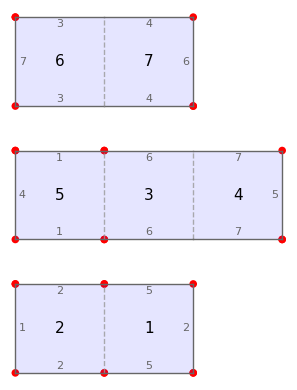

In [71]:
ori = Origami('(1,2)(3,4,5)(6,7)','(1,5)(2)(3,6)(4,7)')
ori.show()